### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 获取Mnist数据集
- 会自动进行下载

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision

In [3]:
train_data = torchvision.datasets.MNIST(
    root = "../../../../datas/minist",
    train = True,
    download = True,
) 

In [4]:
test_data = torchvision.datasets.MNIST(
    root = "../../../../datas/minist",
    train = False,
    download = True,
) 

(-0.5, 27.5, 27.5, -0.5)

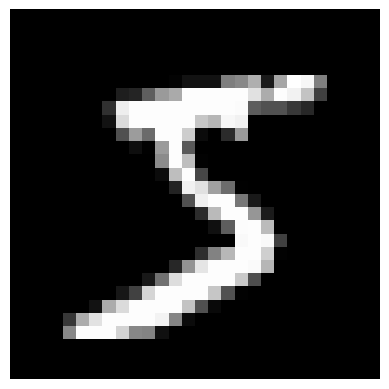

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img = np.array(train_data.data[0])
plt.imshow(img,cmap="gray")
plt.axis("off")

784是mnist数据集每个样本的像素点个数

In [6]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [7]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [8]:
test_data.data.shape

torch.Size([10000, 28, 28])

### 创建一个model来简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [9]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super(Mnist_NN,self).__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1,784).float()
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.out(x)
        return x
        

In [10]:
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


可以打印我们定义好名字里的权重和偏置项

In [11]:
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[-0.0040, -0.0097,  0.0085,  ..., -0.0269,  0.0322,  0.0353],
        [ 0.0078,  0.0161,  0.0235,  ..., -0.0204,  0.0207, -0.0185],
        [ 0.0170, -0.0173, -0.0086,  ..., -0.0352, -0.0167, -0.0014],
        ...,
        [ 0.0098, -0.0191,  0.0134,  ..., -0.0157, -0.0311,  0.0075],
        [-0.0334, -0.0153,  0.0130,  ...,  0.0193,  0.0140,  0.0232],
        [ 0.0232, -0.0143,  0.0119,  ...,  0.0022,  0.0161, -0.0227]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-3.3642e-02,  2.5441e-02,  3.3381e-02, -5.6116e-03,  3.4238e-02,
         2.8001e-02,  1.4710e-02,  1.9611e-02, -2.3240e-02, -8.1089e-03,
        -2.1296e-02, -3.3289e-02, -7.3214e-03,  3.0792e-02,  3.8931e-03,
         6.3274e-03, -2.6595e-02, -1.3284e-02, -2.2624e-03, -2.6035e-02,
         3.2228e-02,  2.8781e-02, -2.9554e-03, -2.0021e-02, -2.8798e-03,
        -1.1618e-02, -5.7124e-03, -1.6995e-03, -2.3038e-02,  3.1471e-02,
      

### 使用TensorDataset和DataLoader来简化

In [12]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(train_data.data, train_data.targets)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

test_ds = TensorDataset(test_data.data, test_data.targets)
test_dl = DataLoader(test_ds, batch_size=64)

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()
epoch = 10
test_data_size = len(test_data)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Mnist_NN()
model.to(device)
loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [15]:
for i in range(epoch):
    print("-------------第{}轮训练开始------------".format(i+1))
    # 训练步骤开始
    model.train()
    for data in train_dl:
        imgs,targets = data
        imgs = imgs.to(device)
        targets = targets.to(device)
        outputs = model(imgs)
        loss = loss_fn(outputs,targets)
        
        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("训练轮数：{},loss:{}".format(i,loss.item()))
        
    # 测试步骤
    model.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for data in test_dl:
            imgs,targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs,targets)
            total_test_loss += loss.item()
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy+=accuracy
    print("整体测试集上的loss:{}".format(total_test_loss))
    print("整体测试集上的正确率:{}".format(total_accuracy/test_data_size))


-------------第1轮训练开始------------
训练轮数：0,loss:1.6495147943496704
整体测试集上的loss:214.42943215370178
整体测试集上的正确率:0.4185999929904938
-------------第2轮训练开始------------
训练轮数：1,loss:1.5054289102554321
整体测试集上的loss:250.82718515396118
整体测试集上的正确率:0.3027999997138977
-------------第3轮训练开始------------
训练轮数：2,loss:1.5917181968688965
整体测试集上的loss:248.75842916965485
整体测试集上的正确率:0.3005000054836273
-------------第4轮训练开始------------
训练轮数：3,loss:1.5193969011306763
整体测试集上的loss:248.14816570281982
整体测试集上的正确率:0.3019999861717224
-------------第5轮训练开始------------
训练轮数：4,loss:1.3976194858551025
整体测试集上的loss:248.40034306049347
整体测试集上的正确率:0.3073999881744385
-------------第6轮训练开始------------
训练轮数：5,loss:1.6058297157287598
整体测试集上的loss:247.24207997322083
整体测试集上的正确率:0.3075000047683716
-------------第7轮训练开始------------
训练轮数：6,loss:1.2807888984680176
整体测试集上的loss:249.8283532857895
整体测试集上的正确率:0.3061999976634979
-------------第8轮训练开始------------
训练轮数：7,loss:2.2376046180725098
整体测试集上的loss:320.39920461177826
整体测试集上的正确率:0.19679999351501465
